Importing the necessary libraries

In [2]:
import numpy as np
import random
from typing import List, Tuple
import matplotlib.pyplot as plt

Defining the ACO with RL class

In [3]:
class ACORL_TSP:
    """
    A hybrid solver combining Ant Colony Optimization (ACO) with Reinforcement Learning (RL)
    for solving the Traveling Salesman Problem (TSP).
    
    The algorithm enhances traditional ACO by using Q-learning to adapt the decision-making
    process and improve exploration/exploitation balance.
    """

    def __init__(
        self,
        distance_matrix: np.ndarray,
        num_ants: int = 5,
        num_iterations: int = 100,
        alpha: float = 1.0,          # Pheromone influence
        beta: float = 2.0,           # Heuristic influence
        evaporation_rate: float = 0.5,
        q_factor: float = 100,       # Pheromone deposit factor
        learning_rate: float = 0.1,  # Q-learning rate
        discount_factor: float = 0.9, # Q-learning discount
        epsilon: float = 0.1         # Exploration probability
    ):
        # Problem parameters
        self.distance_matrix = distance_matrix
        self.num_cities = distance_matrix.shape[0]
        
        # Algorithm parameters
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.q_factor = q_factor
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon

        # Initialize optimization matrices
        self.pheromones = np.ones_like(distance_matrix) / self.num_cities
        self.q_table = np.zeros((self.num_cities, self.num_cities))

        # Track optimization progress
        self.best_route = None
        self.best_length = float('inf')
        self.history = []

    def calculate_route_length(self, route: List[int]) -> float:
        """Calculate the total length of a route in the TSP graph."""
        return sum(self.distance_matrix[route[i], route[i+1]]
                  for i in range(len(route) - 1))

    def select_next_city(self, current_city: int, visited: set,
                        use_q_table: bool = True) -> int:
        """
        Select the next city using a hybrid ACO-RL decision process.
        
        Args:
            current_city: Index of the current city
            visited: Set of already visited cities
            use_q_table: Whether to include Q-learning information
        """
        # Implement epsilon-greedy exploration
        if random.random() < self.epsilon:
            unvisited = list(set(range(self.num_cities)) - visited)
            return random.choice(unvisited) if unvisited else current_city

        # Calculate transition probabilities
        pheromone = self.pheromones[current_city]
        visibility = 1.0 / (self.distance_matrix[current_city] + 1e-10)

        probabilities = np.zeros(self.num_cities)
        unvisited_mask = np.ones(self.num_cities, dtype=bool)
        for city in visited:
            unvisited_mask[city] = False

        # Combine ACO and RL components for decision making
        if use_q_table:
            q_values = self.q_table[current_city]
            q_values = (q_values - q_values.min()) / (q_values.max() - q_values.min() + 1e-10)
            probabilities[unvisited_mask] = (
                (pheromone[unvisited_mask] ** self.alpha) *
                (visibility[unvisited_mask] ** self.beta) *
                (1 + q_values[unvisited_mask])
            )
        else:
            probabilities[unvisited_mask] = (
                (pheromone[unvisited_mask] ** self.alpha) *
                (visibility[unvisited_mask] ** self.beta)
            )

        # Handle zero probability case
        if np.sum(probabilities) == 0:
            unvisited = list(set(range(self.num_cities)) - visited)
            return random.choice(unvisited) if unvisited else current_city

        probabilities /= np.sum(probabilities)
        return np.random.choice(range(self.num_cities), p=probabilities)

    def update_q_table(self, route: List[int], reward: float):
        """
        Update Q-values using temporal difference learning.
        
        Args:
            route: List of cities in the order they were visited
            reward: Reward value for the complete route
        """
        for i in range(len(route) - 1):
            current_city = route[i]
            next_city = route[i + 1]

            current_q = self.q_table[current_city, next_city]
            next_max_q = np.max(self.q_table[next_city])

            # TD learning update
            td_error = reward + self.discount_factor * next_max_q - current_q
            self.q_table[current_city, next_city] += self.learning_rate * td_error

    def update_pheromones(self, all_routes: List[List[int]],
                         all_lengths: List[float]):
        """
        Update pheromone trails using both ACO rules and Q-learning information.
        
        Args:
            all_routes: List of routes from all ants
            all_lengths: Corresponding route lengths
        """
        # Standard ACO pheromone evaporation
        self.pheromones *= (1 - self.evaporation_rate)

        # Deposit new pheromones based on route quality
        for route, route_length in zip(all_routes, all_lengths):
            deposit = self.q_factor / route_length
            for i in range(len(route) - 1):
                self.pheromones[route[i], route[i+1]] += deposit

        # Incorporate Q-learning information
        normalized_q = (self.q_table - self.q_table.min()) / \
                      (self.q_table.max() - self.q_table.min() + 1e-10)
        self.pheromones += 0.1 * normalized_q
        
        # Bound pheromone values for stability
        self.pheromones = np.clip(self.pheromones, 1e-10, 1.0)

    def optimize(self) -> Tuple[List[int], float]:
        """
        Execute the main optimization loop combining ACO and RL approaches.
        
        Returns:
            Tuple containing the best route found and its length
        """
        for iteration in range(self.num_iterations):
            all_routes = []
            all_lengths = []

            # Generate solutions with all ants
            for _ in range(self.num_ants):
                # Initialize ant's tour
                start_city = random.randint(0, self.num_cities - 1)
                visited = {start_city}
                route = [start_city]

                # Construct complete tour
                while len(visited) < self.num_cities:
                    next_city = self.select_next_city(route[-1], visited)
                    route.append(next_city)
                    visited.add(next_city)

                route.append(route[0])  # Complete the cycle
                route_length = self.calculate_route_length(route)
                
                all_routes.append(route)
                all_lengths.append(route_length)
                
                # Update Q-values based on route quality
                self.update_q_table(route, self.q_factor / route_length)

            # Update best solution if improved
            current_best_idx = np.argmin(all_lengths)
            current_best_length = all_lengths[current_best_idx]
            
            if current_best_length < self.best_length:
                self.best_length = current_best_length
                self.best_route = all_routes[current_best_idx]
                print(f"New best found at iteration {iteration + 1}: {self.best_length}")
            
            # Update pheromones and store history
            self.update_pheromones(all_routes, all_lengths)
            self.history.append(current_best_length)

            # Print progress periodically
            if (iteration + 1) % 10 == 0:
                self._print_iteration_stats(iteration + 1, current_best_length,
                                         all_lengths)

        return self.best_route, self.best_length

    def _print_iteration_stats(self, iteration: int, current_best: float,
                             all_lengths: List[float]):
        """Helper method to print iteration statistics."""
        print(f"Iteration {iteration}:")
        print(f"  Current Best Length = {current_best}")
        print(f"  Global Best Length = {self.best_length}")
        print(f"  Average Length = {np.mean(all_lengths)}")
        print(f"  Pheromone Range: [{self.pheromones.min():.4f}, "
              f"{self.pheromones.max():.4f}]")
        print(f"  Q-table Range: [{self.q_table.min():.4f}, "
              f"{self.q_table.max():.4f}]")

    def plot_convergence(self):
        """Plot convergence history showing both iteration-best and global-best values."""
        plt.figure(figsize=(12, 6))
        
        plt.plot(self.history, label='Iteration Best', color='blue', alpha=0.6)
        running_min = np.minimum.accumulate(self.history)
        plt.plot(running_min, label='Global Best', color='red', linestyle='--')
        
        plt.xlabel('Iteration')
        plt.ylabel('Route Length')
        plt.title('Convergence History')
        plt.legend()
        plt.grid(True)
        plt.show()

Testing the Flow

New best found at iteration 1: 325.1895267206169
New best found at iteration 2: 290.30677377778755
New best found at iteration 4: 290.3067737777875
Iteration 10:
  Current Best Length = 298.308791007893
  Global Best Length = 290.3067737777875
  Average Length = 394.22959072160364
  Pheromone Range: [0.0349, 1.0000]
  Q-table Range: [0.0000, 1.4853]
Iteration 20:
  Current Best Length = 315.8059585330885
  Global Best Length = 290.3067737777875
  Average Length = 408.92623841575846
  Pheromone Range: [0.0122, 1.0000]
  Q-table Range: [0.0000, 2.1407]
Iteration 30:
  Current Best Length = 323.93414244013013
  Global Best Length = 290.3067737777875
  Average Length = 399.6782060598332
  Pheromone Range: [0.0042, 1.0000]
  Q-table Range: [0.0000, 2.4004]
Iteration 40:
  Current Best Length = 353.5992574418215
  Global Best Length = 290.3067737777875
  Average Length = 419.8015724378882
  Pheromone Range: [0.0015, 1.0000]
  Q-table Range: [0.0000, 2.5005]
Iteration 50:
  Current Best Lengt

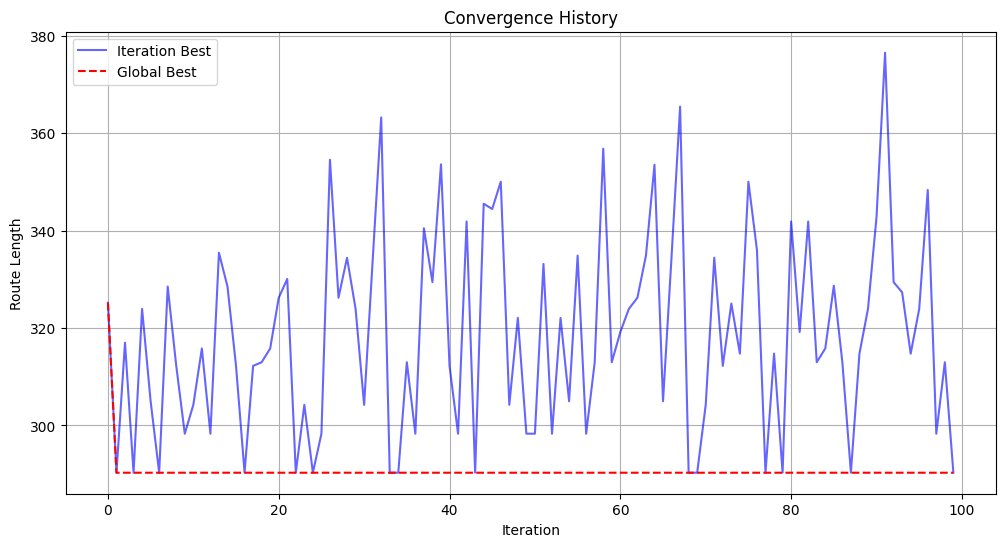

In [4]:
if __name__ == "__main__":
    # Generate a random TSP instance
    np.random.seed(42)
    num_cities = 10
    cities = np.random.rand(num_cities, 2) * 100
    
    
    # Calculate distance matrix
    distance_matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            if i != j:
                distance_matrix[i,j] = np.sqrt(np.sum((cities[i] - cities[j])**2))

    
    
    # Initialize and run optimizer
    optimizer = ACORL_TSP(
        distance_matrix=distance_matrix,
        num_ants=20,
        num_iterations=100,
        alpha=1.0,
        beta=3.0,
        evaporation_rate=0.1,
        q_factor=100,
        learning_rate=0.1,
        discount_factor=0.9,
        epsilon=0.15
    )

    best_route, best_length = optimizer.optimize()
    print(f"\nFinal Best Route: {best_route}")
    print(f"Final Route Length: {best_length}")
    
    optimizer.plot_convergence()